<a href="https://colab.research.google.com/github/sawandarekar/era_v3_assignment_7/blob/main/era_v3_assignment_7_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Situation
Build Model CIFAR10 Dataset with architecture having C1,C2, C3 and C4 convolutions (No MaxPooling, but convolutions, where the last one has a stride of 2 instead) (NO restriction on using 1x1) (If you can figure out how to use Dilated kernels here instead of MP or strided convolution, then 200pts extra!)

## Task
- total RF must be more than 44
- one of the layers must use Depthwise Separable Convolution
- one of the layers must use Dilated Convolution
- use GAP (compulsory):- add FC after GAP to target #of classes (optional)
- use albumentation library and apply:
    - horizontal flip
    - shiftScaleRotate
    - coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
- achieve 85% accuracy, as many epochs as you want. Total Params to be less than 200k.
- make sure you're following code-modularity (else 0 for full assignment) 
- upload to Github

## Action
- Change dataset to CIFAR10
- Update the Module architecture
- Update image transformations
- Limit total params to less than 200k
- Set-up github repo, and upload to github

## Solution


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


## Model Defination

In [21]:
class C1C2C3C4_Model(nn.Module):
    def __init__(self):
        super(C1C2C3C4_Model, self).__init__()

        drop_out_value = 0.1

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=28, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(28),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size =    RF=

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size =   RF=
        
        # self.skip1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size =    RF=

        # TRANSITION BLOCK 1
        # self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output_size =   

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size =    RF=

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5) 
        )


        #self.skip2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False)

        # OUTPUT BLOCK
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            # nn.ReLU(),
            # nn.BatchNorm2d(10),# affine=False),
            #nn.Dropout(drop_out_value)
        ) # output_size =   RF=
        



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = self.convblock5(x)

        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)



## Model Parameters Deatils

In [22]:
!pip install torchsummary
from torchsummary import summary

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print(device)
# model = Net().to(device)
# summary(model, input_size=(1, 28, 28))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = C1C2C3C4_Model().to(device)
summary(model, input_size=(3, 28, 28))

device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"

model = C1C2C3C4_Model().to(device)

Defaulting to user installation because normal site-packages is not writeable
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 28, 28]             756
              ReLU-2           [-1, 28, 28, 28]               0
       BatchNorm2d-3           [-1, 28, 28, 28]              56
           Dropout-4           [-1, 28, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]          16,128
              ReLU-6           [-1, 64, 28, 28]               0
       BatchNorm2d-7           [-1, 64, 28, 28]             128
           Dropout-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]           9,216
             ReLU-10           [-1, 16, 28, 28]               0
      BatchNorm2d-11           [-1, 16, 28, 28]              32
          Dropout-12           [-1, 16, 28, 28]               0
           Conv2d-13     

## Training valiating

In [23]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'EPOCH:{epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f} LR={optimizer.param_groups[0]["lr"]}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Training and testing model for each EPOCH

In [24]:
from torch.optim.lr_scheduler import StepLR

model =  C1C2C3C4_Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/782 [00:00<?, ?it/s]


ValueError: Expected input batch_size (1024) to match target batch_size (64).

Text(0.5, 1.0, 'Test Accuracy')

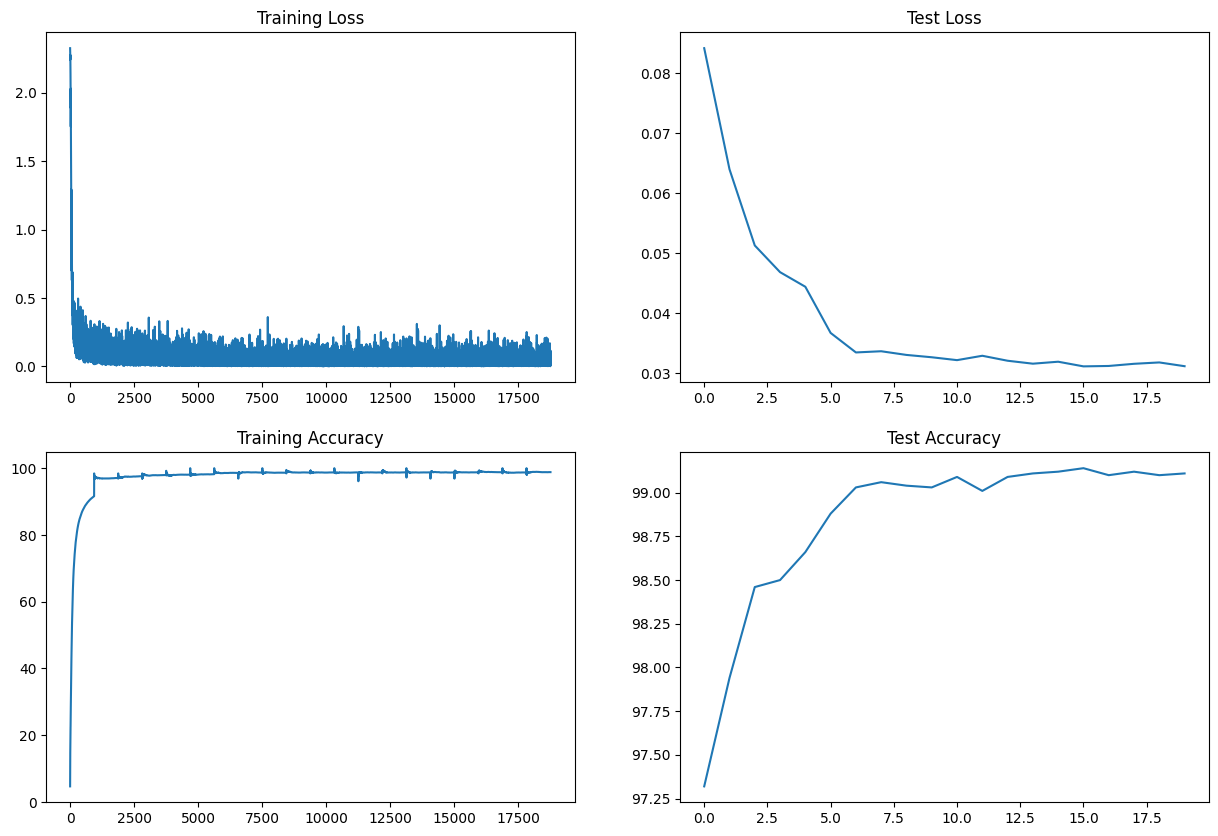

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")